# Clustering trials

## Setup

### Imports

In [1]:
import datetime, os, json, random, sys
from pathlib import Path
from time import time
from typing import Any, Dict, List, Literal, Optional, Union, Tuple
from tqdm import tqdm

import numpy as np
import numpy.typing as npt
import pandas as pd
import plotly.express as px
import torch
import umap
import yaml
from langchain.embeddings import HuggingFaceEmbeddings
from loguru import logger
from rich import print
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from transformers import AutoTokenizer, BertModel, BertTokenizer, BertTokenizerFast

In [2]:
# check GPU availability
sys.path.append("../")
from src.ai_news_digest.utils import check_gpu_availability, create_run_folder
from src.ai_news_digest.steps.benchmark import entropy

### Set random seeds

In [3]:
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

### Check GPU availability

In [4]:
device = check_gpu_availability()

2024-01-21 19:46:45.620 | INFO     | src.ai_news_digest.utils:check_gpu_availability:49 - Is cuda available ? --> True


_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090 Ti', major=8, minor=6, total_memory=24563MB, 
multi_processor_count=84)

2024-01-21 19:46:45.660 | INFO     | src.ai_news_digest.utils:check_gpu_availability:55 - Chose following device: 'cuda:0'


### Config

In [5]:
MODEL_CONFIG_PATH = "../conf/base/cluster_bench_models.yml"
DATA_PATH = "../data/03_primary/arxiv_dict_2023-11-06_00-22-42.json"

MODEL_KWARGS = {"device": device}
ENCODE_KWARGS = {
    "normalize_embeddings": True,
    "batch_size": 16,
    "output_value": "sentence_embedding",
    "convert_to_numpy": True,
    "show_progress_bar": True,
}

In [6]:
PATH_INFO_DICT = "data/03_primary/arxiv_dict_2023-11-06_00-22-42.json"
MODEL_ID = "BAAI/bge-small-en"

## Load data

In [7]:
# load data
with open(DATA_PATH, "r") as f:
    info_dict = json.load(f)["results"]
logger.info(f"Successfully loaded prepared data from : {DATA_PATH}")

# retrieve abstracts, titles, dates & paper IDs
df_data = pd.DataFrame(info_dict).transpose()

# display
df_data.head()

2024-01-21 19:46:45.746 | INFO     | __main__:<module>:4 - Successfully loaded prepared data from : ../data/03_primary/arxiv_dict_2023-11-06_00-22-42.json


,title,abstract,date,category
http://arxiv.org/abs/2311.01425v1,Exploring Deep Learning Techniques for Glaucom...,Glaucoma is one of the primary causes of visio...,2023-11-02 17:39:40+00:00,eess.IV
http://arxiv.org/abs/2311.01352v1,Deep learning based Image Compression for Micr...,With the fast development of modern microscope...,2023-11-02 16:00:32+00:00,eess.IV
http://arxiv.org/abs/2311.01241v1,Exploring Deep Learning Image Super-Resolution...,In this work we test the ability of deep learn...,2023-11-02 13:57:48+00:00,eess.IV
http://arxiv.org/abs/2311.01130v1,A deep learning experiment for semantic segmen...,Palimpsests refer to historical manuscripts wh...,2023-11-02 10:25:47+00:00,cs.CV
http://arxiv.org/abs/2311.01061v1,Deep Learning for real-time neural decoding of...,Neural decoding involves correlating signals a...,2023-11-02 08:26:29+00:00,cs.LG


## Embed Data

In [8]:
# load model
hf = HuggingFaceEmbeddings(
    model_name=MODEL_ID,
    model_kwargs={"device": device},
    encode_kwargs=ENCODE_KWARGS,
)

In [9]:
# compute embeddings
embeddings = np.array(hf.embed_documents(df_data["abstract"]))

# store embeddings in a dataframe
df_embed = pd.DataFrame(
    data=embeddings, 
    columns=[f"embed_{i}" for i in range(embeddings.shape[1])],
    index=df_data.index
)

# display
df_embed.head()

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
http://arxiv.org/abs/2311.01425v1,-0.001384,-0.009538,0.033621,0.015548,0.049827,0.052703,0.042258,0.009232,-0.011007,-0.016927,...,-0.022196,-0.004898,-0.032707,0.004455,-0.017643,-0.007212,-0.065930,-0.036846,-0.000682,-0.009616
http://arxiv.org/abs/2311.01352v1,-0.002659,-0.010493,0.005734,0.018259,0.056982,0.040098,-0.018745,0.010841,0.017799,0.002271,...,0.024147,-0.013133,-0.048883,0.008194,-0.012212,0.048880,-0.050996,-0.051632,0.037865,-0.019642
http://arxiv.org/abs/2311.01241v1,-0.025940,-0.004279,-0.002302,-0.010307,0.044994,0.062084,-0.002210,0.006609,0.020242,-0.006194,...,-0.006990,-0.019892,-0.021326,-0.021109,0.002532,0.006111,-0.024448,-0.020554,0.012528,-0.004717
http://arxiv.org/abs/2311.01130v1,-0.038666,0.013733,0.005050,0.005592,0.002929,0.026078,-0.004111,-0.005976,0.033418,-0.019905,...,-0.029723,-0.032662,-0.027974,0.000945,0.003917,-0.009779,-0.032067,0.007589,0.006462,-0.008279
http://arxiv.org/abs/2311.01061v1,-0.015999,-0.018669,0.000763,-0.013080,0.023814,0.046864,0.060731,-0.004812,0.036577,-0.033680,...,-0.009631,0.009133,-0.049814,0.008142,-0.012620,0.073099,-0.062735,-0.003177,-0.027720,-0.001277


## Dimensionality reduction

In [10]:
# set umap params
umap_kwargs = {
    "n_neighbors": 5,
    "min_dist": 0.001,
    "n_components": 2,
    "metric": "cosine",
}

# instanciate umap projector
reducer = umap.UMAP(random_state=123, **umap_kwargs)

# project data
umap_proj = reducer.fit_transform(df_embed)

# normalize umap coords
umap_proj = (umap_proj - umap_proj.min(axis=0)) / (umap_proj.max(axis=0) - umap_proj.min(axis=0))

# store in a dataframe with metadata
df_umap = pd.DataFrame(columns=[f"umap_{i}" for i in range(umap_proj.shape[1])], data=umap_proj)
df_umap = pd.concat((df_umap, df_data.reset_index(names=["ID"])), axis=1)

# display
df_umap.head()

,umap_0,umap_1,ID,title,abstract,date,category
0,0.824424,0.279553,http://arxiv.org/abs/2311.01425v1,Exploring Deep Learning Techniques for Glaucom...,Glaucoma is one of the primary causes of visio...,2023-11-02 17:39:40+00:00,eess.IV
1,0.611574,0.570841,http://arxiv.org/abs/2311.01352v1,Deep learning based Image Compression for Micr...,With the fast development of modern microscope...,2023-11-02 16:00:32+00:00,eess.IV
2,0.609362,0.553106,http://arxiv.org/abs/2311.01241v1,Exploring Deep Learning Image Super-Resolution...,In this work we test the ability of deep learn...,2023-11-02 13:57:48+00:00,eess.IV
3,0.876372,0.672962,http://arxiv.org/abs/2311.01130v1,A deep learning experiment for semantic segmen...,Palimpsests refer to historical manuscripts wh...,2023-11-02 10:25:47+00:00,cs.CV
4,0.554575,0.434635,http://arxiv.org/abs/2311.01061v1,Deep Learning for real-time neural decoding of...,Neural decoding involves correlating signals a...,2023-11-02 08:26:29+00:00,cs.LG


## Clustering

In [11]:
X_cluster = df_umap[[col for col in df_umap.columns if "umap" in col]]

clustering = HDBSCAN(
    min_cluster_size=10, 
    min_samples=3, 
    max_cluster_size=None, 
    cluster_selection_epsilon=0.05
)
clustering.fit(X_cluster)

HDBSCAN(cluster_selection_epsilon=0.05, min_cluster_size=10, min_samples=3)

In [12]:
# viz
df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
fig = px.scatter(
    df_umap,
    x="umap_0",
    y="umap_1",
    hover_data=[
        "title",
        "ID",
    ],
    color="cluster",
    symbol="noise",
    # color_continuous_scale=px.colors.qualitative.D3,
    category_orders={"cluster": list(np.sort(pd.unique(clustering.labels_)).astype(str))},
)
fig.show()

In [13]:
# Entropy ↓
entropy(X_cluster.values)

5.506120411799392

In [14]:
# Silhouette ↑
silhouette_score(X_cluster, df_umap["cluster"])

0.38029325

## Refacto projection & clustering pipeline

In [15]:
def clustering_pipeline(
    df_embed: pd.DataFrame,
    umap_kwargs: dict,
    clustering_kwargs: Optional[dict]=None,
    random_state: int=123,
    df_data: Optional[pd.DataFrame]=None,
) -> Tuple[pd.DataFrame, Any]:
    
    #--- dimensionality reduction ---

    # instanciate umap projector
    reducer = umap.UMAP(random_state=random_state, **umap_kwargs)

    # project data
    umap_proj = reducer.fit_transform(df_embed)

    # normalize umap coords
    umap_proj = (umap_proj - umap_proj.min(axis=0)) / (umap_proj.max(axis=0) - umap_proj.min(axis=0))

    # store in a dataframe
    df_umap = pd.DataFrame(columns=[f"umap_{i}" for i in range(umap_proj.shape[1])], data=umap_proj)

    # add metadata if available
    if df_data is not None:
        df_umap = pd.concat((df_umap, df_data.reset_index(names=["ID"])), axis=1)

    #--- clustering ---
    if clustering_kwargs is not None:
        X_cluster = df_umap[[col for col in df_umap.columns if "umap" in col]]
        clustering = HDBSCAN(**clustering_kwargs)
        clustering.fit(X_cluster)
        df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
        df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
    
    else:
        clustering = None

    #--- result ---
    return df_umap, clustering

In [16]:
clustering_kwargs = {    
    "min_cluster_size": 10, 
    "min_samples": 3, 
    "max_cluster_size": None, 
    "cluster_selection_epsilon": 0.05,
}

umap_kwargs = {
    "n_neighbors": 5,
    "min_dist": 0.1,
    "n_components": 2,
    "metric": "cosine",
}

df_umap, clustering = clustering_pipeline(
    df_embed,
    umap_kwargs,
    clustering_kwargs,
    random_state=123,
    df_data=df_data,
)

X_cluster = df_umap[[c for c in df_umap.columns if "umap_" in c]]

# Silhouette ↑
print(f" Silhouette ↑ = {silhouette_score(X_cluster, df_umap['cluster'])}")

# Entropy ↓
print(f" Entropy ↓ = {entropy(X_cluster.values)}")

# viz
df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
fig = px.scatter(
    df_umap,
    x="umap_0",
    y="umap_1",
    hover_data=[
        "title",
        "ID",
    ],
    color="cluster",
    symbol="noise",
    # color_continuous_scale=px.colors.qualitative.D3,
    category_orders={"cluster": list(np.sort(pd.unique(clustering.labels_)).astype(str))},
)
fig.show()

Silhouette ↑ = 0.1943456530570984

Entropy ↓ = 5.9015601498429815

## Grid search over projection and clustering parameters

In [31]:
# from itertools import product
from tqdm.contrib.itertools import product

clustering_grid = {
    "min_cluster_size": [3, 5, 10, 15], 
    "min_samples": [3, 5, 10], 
    "max_cluster_size": [None, 15, 25, 40], 
    "cluster_selection_epsilon": [
        # 0.0, 
        # 0.05, 
        # 0.0,
        # 0.001,
        # 0.01,
        0.05,
        0.1,    
        0.5,    
    ],
}

umap_grid = {
    "n_neighbors": [2, 4, 8, 10],
    "min_dist": [0.001, 0.01, 0.1, 0.5],
    "n_components": [2],
    "metric": ["cosine"],
    "init": ["random"],
}


In [32]:
best_entropy = np.inf
best_umap_kwargs = None
df_umap_search = pd.DataFrame(columns=list(umap_grid.keys())+["Entropy ↓"])

for umap_vals in product(*tuple(umap_grid.values())):
    
    # retrieve current umap kwargs
    umap_kwargs = {}
    for i, key in enumerate(umap_grid.keys()):
        umap_kwargs[key] = umap_vals[i]
    
    try:
        df_umap, clustering = clustering_pipeline(
            df_embed,
            umap_kwargs,
            clustering_kwargs=None,
            random_state=123,
            df_data=df_data,
        )
        X_cluster = df_umap[[c for c in df_umap.columns if "umap_" in c]]
        curr_entropy = entropy(X_cluster.values)
        df_umap_search = pd.concat(
            (
                df_umap_search,
                pd.DataFrame(data=np.array([umap_vals+(curr_entropy,)]), columns=df_umap_search.columns)
            ),
            axis=0,
            ignore_index=True,
        )

        if curr_entropy < best_entropy:
            best_entropy = curr_entropy
            best_umap_kwargs = umap_kwargs
        
    except Exception as e:
        print(f" {umap_kwargs} failed with following error: {e}; will proceed to next iteration")
    
print(f"Best entropy: {best_entropy}")
print(f"Best umap_kwargs: {best_umap_kwargs}")

df_umap_search

  0%|          | 0/16 [00:00<?, ?it/s]

Best entropy: 5.336908360372046

Best umap_kwargs: {'n_neighbors': 4, 'min_dist': 0.001, 'n_components': 2, 'metric': 'cosine', 'init': 'random'}

,n_neighbors,min_dist,n_components,metric,init,Entropy ↓
0,2,0.001,2,cosine,random,5.670807492208298
1,2,0.01,2,cosine,random,5.6585034408010815
2,2,0.1,2,cosine,random,5.661407034350974
3,2,0.5,2,cosine,random,5.758559899441392
4,4,0.001,2,cosine,random,5.336908360372046
5,4,0.01,2,cosine,random,5.533218615134583
6,4,0.1,2,cosine,random,5.685510044054403
7,4,0.5,2,cosine,random,6.045011360014577
8,8,0.001,2,cosine,random,5.45305860147179
9,8,0.01,2,cosine,random,5.498777250550915


In [33]:
best_silhouette = -np.inf
best_clustering_kwargs = None
df_clustering_search = pd.DataFrame(columns=list(clustering_grid.keys())+["Silhouette ↑"])

for clustering_vals in product(*tuple(clustering_grid.values())):
    
    # retrieve current clustering kwargs
    clustering_kwargs = {}
    for i, key in enumerate(clustering_grid.keys()):
        clustering_kwargs[key] = clustering_vals[i]
    
    try:
        df_umap, clustering = clustering_pipeline(
            df_embed,
            best_umap_kwargs,
            clustering_kwargs=clustering_kwargs,
            random_state=123,
            df_data=df_data,
        )
        X_cluster = df_umap[[c for c in df_umap.columns if "umap_" in c]]
        curr_silhouette = silhouette_score(X_cluster.values, df_umap["cluster"])
        df_clustering_search = pd.concat(
            (
                df_clustering_search,
                pd.DataFrame(data=np.array([clustering_vals+(curr_silhouette,)]), columns=df_clustering_search.columns)
            ),
            axis=0,
            ignore_index=True,
        )

        if curr_silhouette > best_silhouette:
            best_silhouette = curr_silhouette
            best_clustering_kwargs = clustering_kwargs
        
    except Exception as e:
        print(f" {umap_kwargs} failed with following error: {e}; will proceed to next iteration")
    
print(f"Best silhouette: {best_silhouette}")
print(f"Best clustering_kwargs: {best_clustering_kwargs}")

df_clustering_search

  0%|          | 0/144 [00:00<?, ?it/s]

{'n_neighbors': 10, 'min_dist': 0.5, 'n_components': 2, 'metric': 'cosine', 'init': 'random'} failed with 
following error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive); will proceed to next 
iteration

{'n_neighbors': 10, 'min_dist': 0.5, 'n_components': 2, 'metric': 'cosine', 'init': 'random'} failed with 
following error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive); will proceed to next 
iteration

{'n_neighbors': 10, 'min_dist': 0.5, 'n_components': 2, 'metric': 'cosine', 'init': 'random'} failed with 
following error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive); will proceed to next 
iteration

Best silhouette: 0.4319193363189697

Best clustering_kwargs: {'min_cluster_size': 15, 'min_samples': 3, 'max_cluster_size': None, 
'cluster_selection_epsilon': 0.05}

,min_cluster_size,min_samples,max_cluster_size,cluster_selection_epsilon,Silhouette ↑
0,3,3,None,0.05,0.295892
1,3,3,None,0.1,0.300708
2,3,3,None,0.5,0.333435
3,3.0,3.0,15.0,0.05,0.295892
4,3.0,3.0,15.0,0.1,0.300708
...,...,...,...,...,...
136,15.0,10.0,25.0,0.1,0.340647
137,15.0,10.0,25.0,0.5,0.340647
138,15.0,10.0,40.0,0.05,0.2845
139,15.0,10.0,40.0,0.1,0.300708


<Axes: >

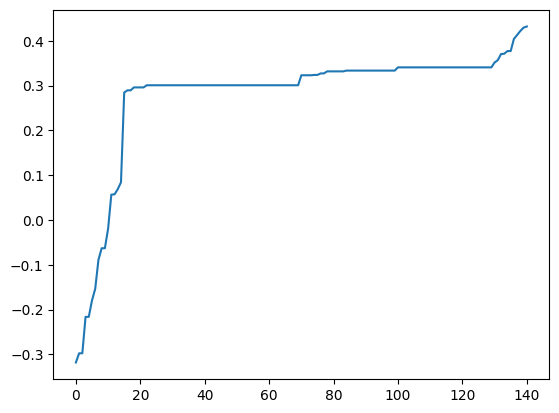

In [34]:
df_clustering_search["Silhouette ↑"].sort_values().reset_index(drop=True).plot()

In [35]:
df_umap, clustering = clustering_pipeline(
    df_embed,
    best_umap_kwargs,
    best_clustering_kwargs,
    random_state=123,
    df_data=df_data,
)

X_cluster = df_umap[[c for c in df_umap.columns if "umap_" in c]]

# Silhouette ↑
print(f" Silhouette ↑ = {silhouette_score(X_cluster, df_umap['cluster'])}")

# Entropy ↓
print(f" Entropy ↓ = {entropy(X_cluster.values)}")

# viz
df_umap["cluster"] = [str(elt) for elt in clustering.labels_]
df_umap["noise"] = [int(elt==-1) for elt in clustering.labels_]
fig = px.scatter(
    df_umap,
    x="umap_0",
    y="umap_1",
    hover_data=[
        "title",
        "ID",
    ],
    color="cluster",
    symbol="noise",
    # color_continuous_scale=px.colors.qualitative.D3,
    category_orders={"cluster": list(np.sort(pd.unique(clustering.labels_)).astype(str))},
)
fig.show()

Silhouette ↑ = 0.4319193363189697

Entropy ↓ = 5.336908360372046